### Run my code directly in Colab  

First I run my code locally, however I thought that it would be not comfortable to the person who is checking my work, so I decided to change my code to be runnable in colab.

Please, firstly download these packages:  

In [ ]:
%pip install -q requests beautifulsoup4 lxml pandas tqdm

### How my solution looks like

At first, I created a requests session with headers to look like a real browser and added retries, so if the site blocks me or gives an error, it will try again automatically. Then I collected all recipe links from the archive pages under /recipes/, up to 50 pages by default. I saved those links into a text file, and if the file already exists, I just load it without recollecting.  

To avoid losing progress, I also used a checkpoint system. Every time I scrape some recipes, I save them into a CSV file called recipes_checkpoint.csv. So if the code stops or crashes, I can continue from where I left off instead of starting again.  

For each recipe page, I used BeautifulSoup to extract the main details: the recipe name, calories, personal points, summary text, first image, recipe keys, and the URL. If something is missing on the page, I just keep it as None. To make it faster, I used ThreadPoolExecutor with multiple workers, so several recipes are scraped at the same time. While it runs, tqdm shows me the progress.  

In the end, I combined everything into a DataFrame and saved it twice: once as a checkpoint during the process and once as a final file called recipes.csv. So this solution can scrape a large amount of recipes, skip the ones already done, and it is more reliable because of retries, checkpoints, and parallel requests.  


In [ ]:
import os, time, math, requests, pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm

MAX_PAGES = 50
SAVE_EVERY = 25
WORKERS = 8
FORCE_RECOLLECT_LINKS = False

LINKS_FILE = "/content/recipes_links.txt"
CHECKPOINT_CSV = "/content/recipes_checkpoint.csv"
FINAL_CSV = "/content/recipes.csv"
BASE = "https://www.skinnytaste.com"

def make_session():
    s = requests.Session()
    s.headers.update({
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/124.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
    })
    retry = Retry(
        total=6,
        connect=3,
        read=3,
        backoff_factor=0.5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"]
    )
    adapter = HTTPAdapter(max_retries=retry)
    s.mount("https://", adapter)
    s.mount("http://", adapter)
    return s

def page_url(n: int) -> str:
    return f"{BASE}/recipes/" if n == 1 else f"{BASE}/recipes/page/{n}/"

def fetch_html(session: requests.Session, url: str, timeout: int = 25) -> str:
    r = session.get(url, timeout=timeout)
    r.raise_for_status()
    return r.text

def collect_links(session: requests.Session, max_pages=MAX_PAGES):
    print(f"Collecting links from archive pages 1..{max_pages} ...")
    links = []
    for n in tqdm(range(1, max_pages + 1)):
        html = fetch_html(session, page_url(n))
        soup = BeautifulSoup(html, "lxml")
        articles = soup.select("article[id^='post-']")
        if not articles:
            print(f"No articles found on page {n} — stopping.")
            break
        for art in articles:
            a = art.select_one("a")
            href = a.get("href") if a else None
            if href and href.startswith("http") and "skinnytaste.com" in href:
                links.append(href)
        time.sleep(0.1)

    seen, uniq = set(), []
    for u in links:
        if u not in seen:
            seen.add(u); uniq.append(u)
    with open(LINKS_FILE, "w", encoding="utf-8") as f:
        f.write("\n".join(uniq))
    print(f"Saved {len(uniq)} unique links to {LINKS_FILE}")
    return uniq

def load_links(session: requests.Session, force=False):
    if not force and os.path.exists(LINKS_FILE):
        with open(LINKS_FILE, "r", encoding="utf-8") as f:
            urls = [ln.strip() for ln in f if ln.strip()]
        print(f"Loaded {len(urls)} links from {LINKS_FILE}")
        return urls
    return collect_links(session, MAX_PAGES)

def load_checkpoint():
    if os.path.exists(CHECKPOINT_CSV):
        df = pd.read_csv(CHECKPOINT_CSV)
        print(f"Loaded checkpoint with {len(df)} rows")
        return df
    return pd.DataFrame(columns=[
        "Recipe Name","Calories","Personal Points","Image URL",
        "Recipe Keys","Summary","URL"
    ])

def save_checkpoint(df: pd.DataFrame):
    df.to_csv(CHECKPOINT_CSV, index=False, encoding="utf-8")
    print(f"[Checkpoint] Saved {len(df)} rows -> {CHECKPOINT_CSV}")

def text(el):
    return el.get_text(strip=True) if el else None

def parse_recipe_html(html: str, url: str):
    soup = BeautifulSoup(html, "lxml")

    name = text(soup.select_one("h1.entry-title"))

    cal  = text(soup.select_one("span.recipe-meta-value.value-calories"))
    pts  = text(soup.select_one("span.recipe-meta-value.recipe-ww-pp.icon"))

    summary = text(soup.select_one("div.wprm-recipe-summary.wprm-block-text-normal > span"))
    if not summary:
        summary = text(soup.select_one("div.entry-content p"))

    img = None
    og = soup.select_one("meta[property='og:image']")
    if og and og.get("content"):
        img = og.get("content")
    if not img:
        imgtag = soup.select_one("article img")
        if imgtag and imgtag.get("src"):
            img = urljoin(BASE, imgtag.get("src"))

    keys = ", ".join(
        [text(a) for a in soup.select("ul.cat-icons.post-icons a") if text(a)]
    ) or None

    return {
        "Recipe Name": name,
        "Calories": cal,
        "Personal Points": pts,
        "Image URL": img,
        "Recipe Keys": keys,
        "Summary": summary,
        "URL": url
    }

def scrape_one(session: requests.Session, url: str):
    try:
        html = fetch_html(session, url)
        return parse_recipe_html(html, url)
    except Exception as e:
        return {
            "Recipe Name": None, "Calories": None, "Personal Points": None,
            "Image URL": None, "Recipe Keys": None, "Summary": None, "URL": url,
        }

session = make_session()

all_links = load_links(session, force=FORCE_RECOLLECT_LINKS)

df_ckpt = load_checkpoint()
done = set(df_ckpt["URL"].dropna().tolist())
todo = [u for u in all_links if u not in done]
print(f"To scrape now: {len(todo)} (already done: {len(done)})")

results = df_ckpt.to_dict("records")
pending = []
since_last_save = 0

def batched(seq, size):
    for i in range(0, len(seq), size):
        yield seq[i:i+size]

BATCH = max(10, SAVE_EVERY)

for batch in batched(todo, BATCH):
    with ThreadPoolExecutor(max_workers=WORKERS) as ex:
        futures = {ex.submit(scrape_one, session, u): u for u in batch}
        for fut in tqdm(as_completed(futures), total=len(futures), desc="Scraping"):
            row = fut.result()
            results.append(row)
            since_last_save += 1

            if since_last_save >= SAVE_EVERY:
                save_checkpoint(pd.DataFrame(results))
                since_last_save = 0

final_df = pd.DataFrame(results)
final_df.to_csv(FINAL_CSV, index=False, encoding="utf-8")
save_checkpoint(final_df)
print(f"\nSaved {len(final_df)} recipes to {FINAL_CSV}")


  0%|          | 0/50 [00:00<?, ?it/s]

Saved 1001 unique links to /content/recipes_links.txt
To scrape now: 1001 (already done: 0)


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 25 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 50 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 75 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 100 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 125 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 150 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 175 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 200 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 225 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 250 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 275 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 300 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 325 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 350 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 375 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 400 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 425 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 450 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 475 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 500 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 525 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 550 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 575 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 600 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 625 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 650 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 675 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 700 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 725 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 750 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 775 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 800 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 825 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 850 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 875 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 900 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 925 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 950 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 975 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/25 [00:00<?, ?it/s]

[Checkpoint] Saved 1000 rows -> /content/recipes_checkpoint.csv


Scraping:   0%|          | 0/1 [00:00<?, ?it/s]

[Checkpoint] Saved 1001 rows -> /content/recipes_checkpoint.csv

Saved 1001 recipes to /content/recipes.csv


If you did not run previous cell, you can just read my dataset with pandas.

In [ ]:
df = pd.read_csv('recipes.csv')

Checking first 5 rows

In [ ]:
df.head()

,Recipe Name,Calories,Personal Points,Image URL,Recipe Keys,Summary,URL
0,Cottage Cheese Queso,Cals:94,4.0,https://www.skinnytaste.com/wp-content/uploads...,"GF, HP, LC, Q, V","This creamy, cheesy Cottage Cheese Queso Dip i...",https://www.skinnytaste.com/cottage-cheese-queso/
1,High-Protein Scrambled Eggs with Cottage Cheese,Cals:173,1.0,https://www.skinnytaste.com/wp-content/uploads...,"HP, LC, Q, V",Add some cottage cheese to your scrambled eggs...,https://www.skinnytaste.com/high-protein-scram...
2,Chicken Shawarma Sheet Pan Dinner,Cals:370.5,1.0,https://www.skinnytaste.com/wp-content/uploads...,"DF, FM, GF, HP, MP",Chicken Shawarma Sheet Pan Dinner is a flavorf...,https://www.skinnytaste.com/chicken-shawarma-s...
3,Air Fryer Meatball Subs,Cals:494,8.0,https://www.skinnytaste.com/wp-content/uploads...,"AF, FM, GF, HP, KF","Air Fryer Meatball Subs are an easy, healthy t...",https://www.skinnytaste.com/air-fryer-meatball...
4,Parmesan Zucchini,Cals:108,4.0,https://www.skinnytaste.com/wp-content/uploads...,"GF, KF, LC, Q, V",Quick and easy Parmesan Zucchini is the perfec...,https://www.skinnytaste.com/parmesan-zucchini/


Checking for null values

In [ ]:
df.isnull().sum()

,0
Recipe Name,0
Calories,176
Personal Points,176
Image URL,0
Recipe Keys,166
Summary,1
URL,0


Dropping null values.

In [ ]:
df.dropna(inplace=True)

Our Calories column looks like 'Cals:494', but we need just the number, so I changed it using:

In [ ]:
df['Calories'] = df['Calories'].apply(lambda x : x.split(':')[1])

In [ ]:
df.head()

,Recipe Name,Calories,Personal Points,Image URL,Recipe Keys,Summary,URL
0,Cottage Cheese Queso,94,4.0,https://www.skinnytaste.com/wp-content/uploads...,"GF, HP, LC, Q, V","This creamy, cheesy Cottage Cheese Queso Dip i...",https://www.skinnytaste.com/cottage-cheese-queso/
1,High-Protein Scrambled Eggs with Cottage Cheese,173,1.0,https://www.skinnytaste.com/wp-content/uploads...,"HP, LC, Q, V",Add some cottage cheese to your scrambled eggs...,https://www.skinnytaste.com/high-protein-scram...
2,Chicken Shawarma Sheet Pan Dinner,370.5,1.0,https://www.skinnytaste.com/wp-content/uploads...,"DF, FM, GF, HP, MP",Chicken Shawarma Sheet Pan Dinner is a flavorf...,https://www.skinnytaste.com/chicken-shawarma-s...
3,Air Fryer Meatball Subs,494,8.0,https://www.skinnytaste.com/wp-content/uploads...,"AF, FM, GF, HP, KF","Air Fryer Meatball Subs are an easy, healthy t...",https://www.skinnytaste.com/air-fryer-meatball...
4,Parmesan Zucchini,108,4.0,https://www.skinnytaste.com/wp-content/uploads...,"GF, KF, LC, Q, V",Quick and easy Parmesan Zucchini is the perfec...,https://www.skinnytaste.com/parmesan-zucchini/


Information about my dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 815 entries, 0 to 1000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Recipe Name      815 non-null    object 
 1   Calories         815 non-null    object 
 2   Personal Points  815 non-null    float64
 3   Image URL        815 non-null    object 
 4   Recipe Keys      815 non-null    object 
 5   Summary          815 non-null    object 
 6   URL              815 non-null    object 
dtypes: float64(1), object(6)
memory usage: 50.9+ KB


Converting obtained Calories column to number

In [ ]:
df['Calories'] = pd.to_numeric(df["Calories"], errors="coerce")

Checking the datatypes

In [ ]:
df.dtypes

,0
Recipe Name,object
Calories,float64
Personal Points,float64
Image URL,object
Recipe Keys,object
Summary,object
URL,object


Converting my Recipe Keys column elements to the list elements

In [ ]:
df['Recipe Keys'] = df['Recipe Keys'].apply(lambda x : x.replace(" ", "").split(','))

In [ ]:
df.head()

,Recipe Name,Calories,Personal Points,Image URL,Recipe Keys,Summary,URL
0,Cottage Cheese Queso,94.0,4.0,https://www.skinnytaste.com/wp-content/uploads...,"[GF, HP, LC, Q, V]","This creamy, cheesy Cottage Cheese Queso Dip i...",https://www.skinnytaste.com/cottage-cheese-queso/
1,High-Protein Scrambled Eggs with Cottage Cheese,173.0,1.0,https://www.skinnytaste.com/wp-content/uploads...,"[HP, LC, Q, V]",Add some cottage cheese to your scrambled eggs...,https://www.skinnytaste.com/high-protein-scram...
2,Chicken Shawarma Sheet Pan Dinner,370.5,1.0,https://www.skinnytaste.com/wp-content/uploads...,"[DF, FM, GF, HP, MP]",Chicken Shawarma Sheet Pan Dinner is a flavorf...,https://www.skinnytaste.com/chicken-shawarma-s...
3,Air Fryer Meatball Subs,494.0,8.0,https://www.skinnytaste.com/wp-content/uploads...,"[AF, FM, GF, HP, KF]","Air Fryer Meatball Subs are an easy, healthy t...",https://www.skinnytaste.com/air-fryer-meatball...
4,Parmesan Zucchini,108.0,4.0,https://www.skinnytaste.com/wp-content/uploads...,"[GF, KF, LC, Q, V]",Quick and easy Parmesan Zucchini is the perfec...,https://www.skinnytaste.com/parmesan-zucchini/


Visualizing Calories Distribution

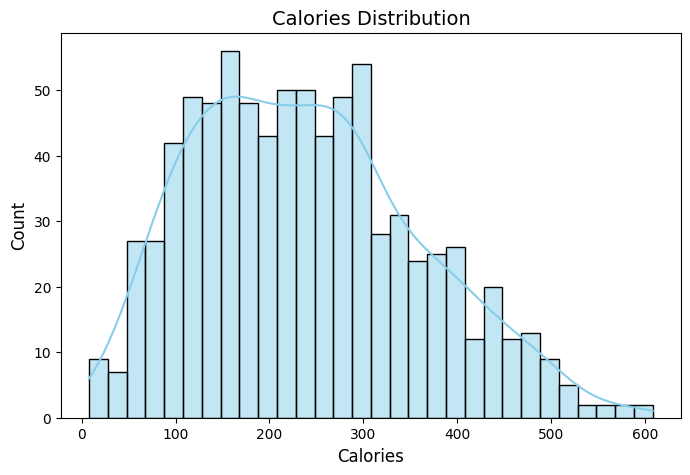

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df["Calories"], bins=30, kde=True, color="skyblue")

plt.title("Calories Distribution", fontsize=14)
plt.xlabel("Calories", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

Visualizing Personal Points Distribution

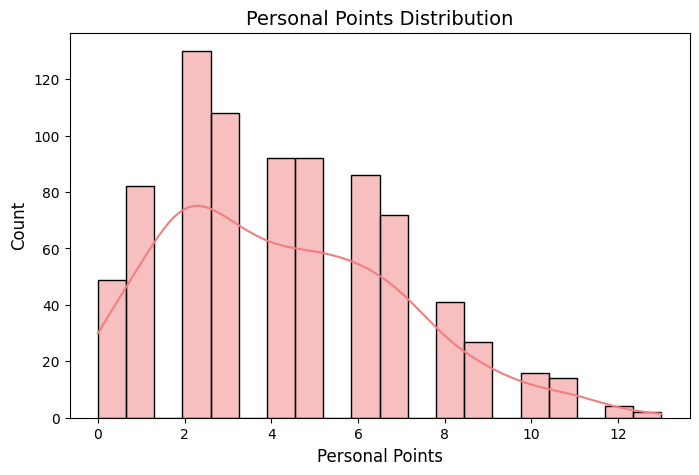

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["Personal Points"], bins=20, kde=True, color="lightcoral")

plt.title("Personal Points Distribution", fontsize=14)
plt.xlabel("Personal Points", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

I just wanted to check if there is correlation between Calories and Personal Points:)

<Axes: xlabel='Calories', ylabel='Personal Points'>

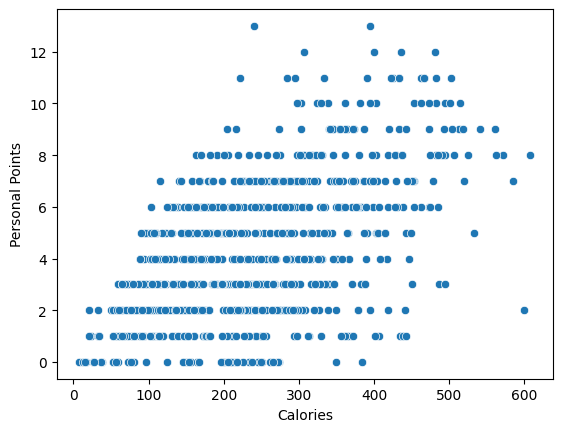

In [ ]:
sns.scatterplot(x="Calories", y="Personal Points", data=df)

Created a new dataframe to explode the list elements of my Recipe Keys column

In [ ]:
keys_exploded = df.explode("Recipe Keys")

In [ ]:
keys_exploded.head()

,Recipe Name,Calories,Personal Points,Image URL,Recipe Keys,Summary,URL
0,Cottage Cheese Queso,94.0,4.0,https://www.skinnytaste.com/wp-content/uploads...,GF,"This creamy, cheesy Cottage Cheese Queso Dip i...",https://www.skinnytaste.com/cottage-cheese-queso/
0,Cottage Cheese Queso,94.0,4.0,https://www.skinnytaste.com/wp-content/uploads...,HP,"This creamy, cheesy Cottage Cheese Queso Dip i...",https://www.skinnytaste.com/cottage-cheese-queso/
0,Cottage Cheese Queso,94.0,4.0,https://www.skinnytaste.com/wp-content/uploads...,LC,"This creamy, cheesy Cottage Cheese Queso Dip i...",https://www.skinnytaste.com/cottage-cheese-queso/
0,Cottage Cheese Queso,94.0,4.0,https://www.skinnytaste.com/wp-content/uploads...,Q,"This creamy, cheesy Cottage Cheese Queso Dip i...",https://www.skinnytaste.com/cottage-cheese-queso/
0,Cottage Cheese Queso,94.0,4.0,https://www.skinnytaste.com/wp-content/uploads...,V,"This creamy, cheesy Cottage Cheese Queso Dip i...",https://www.skinnytaste.com/cottage-cheese-queso/


Visualizing the Distribution of Recipe Keys

/tmp/ipython-input-212195896.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


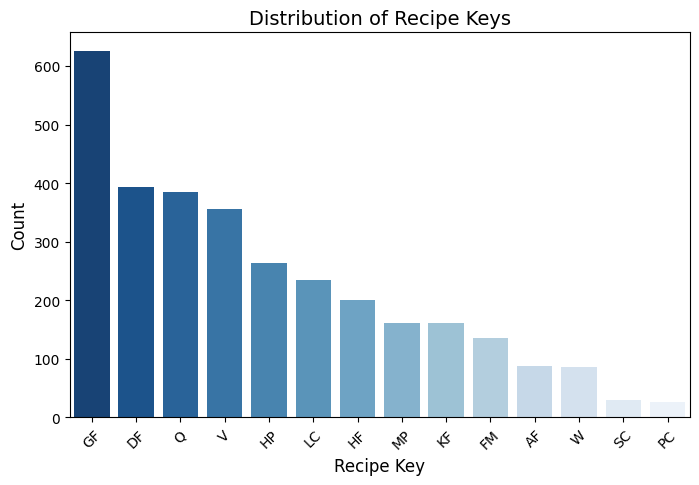

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=keys_exploded,
    x="Recipe Keys",
    order=keys_exploded["Recipe Keys"].value_counts().index,
    palette="Blues_r"
)

plt.title("Distribution of Recipe Keys", fontsize=14)
plt.xlabel("Recipe Key", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

To run the user interaction interface, please download this packages, before running if you want you can see how it looks at the bottom of the page

In [ ]:
%pip install -q gradio pandas requests pillow lxml beautifulsoup4 tqdm

By running this cell, you can have a look to my GUI.

In [ ]:
import os, re, pandas as pd, gradio as gr

CSV_CANDIDATES = ["/content/recipes.csv", "/content/recipes_checkpoint.csv", "recipes.csv"]
csv_path = next((p for p in CSV_CANDIDATES if os.path.exists(p)), None)
if not csv_path:
    raise FileNotFoundError(
        "recipes.csv not found. Put your scraped CSV at /content/recipes.csv (or recipes_checkpoint.csv)."
    )

df = pd.read_csv(csv_path)

def to_int_or_none(x):
    if pd.isna(x):
        return None
    m = re.search(r"(\d+)", str(x))
    return int(m.group(1)) if m else None

df["Calories_num"] = df.get("Calories", pd.Series([None]*len(df))).apply(to_int_or_none)
df["Points_num"]   = df.get("Personal Points", pd.Series([None]*len(df))).apply(to_int_or_none)

def safe_min(series, fallback):
    vals = [v for v in series if pd.notna(v)]
    return int(min(vals)) if vals else fallback

def safe_max(series, fallback):
    vals = [v for v in series if pd.notna(v)]
    return int(max(vals)) if vals else fallback

cmin = safe_min(df["Calories_num"], 0)
cmax = safe_max(df["Calories_num"], 2000)
pmin = safe_min(df["Points_num"], 0)
pmax = safe_max(df["Points_num"], 50)

CARD_CSS = """
<style>
.cards{display:flex;flex-direction:column;gap:16px;max-width:980px;margin:auto;}
.card{border:1px solid #ddd;border-radius:12px;padding:12px;display:flex;gap:12px;align-items:flex-start;}
.card img{width:260px;max-height:200px;object-fit:cover;border-radius:10px;border:1px solid #eee;}
.meta{font-weight:600;margin-bottom:6px}
.title{font-size:17px;font-weight:700;margin-bottom:4px}
.summary{line-height:1.35}
.url a{font-size:12px;color:#555;text-decoration:none}
@media (max-width:720px){.card{flex-direction:column}.card img{width:100%;max-height:240px}}
</style>
"""

def render_cards(rows: pd.DataFrame) -> str:
    html = [CARD_CSS, '<div class="cards">']
    for _, r in rows.iterrows():
        name = r.get("Recipe Name") or "Untitled"
        cal  = r.get("Calories_num")
        pts  = r.get("Points_num")
        summary = (r.get("Summary") or "")[:1000]
        url = r.get("URL") or ""
        img = r.get("Image URL")
        img_ok = isinstance(img, str) and img.startswith("http")
        meta = f"{cal if cal is not None else '—'} cal · {pts if pts is not None else '—'} pts"

        html.append('<div class="card">')
        if img_ok:
            html.append(f'<img src="{img}" loading="lazy" alt="recipe image">')
        html.append('<div>')
        html.append(f'<div class="title">{name}</div>')
        html.append(f'<div class="meta">{meta}</div>')
        if summary:
            html.append(f'<div class="summary">{summary}</div>')
        if url:
            html.append(f'<div class="url"><a href="{url}" target="_blank">{url}</a></div>')
        html.append('</div></div>')
    html.append('</div>')
    return "".join(html)

def search(c_min, c_max, p_min, p_max):
    dd = df.copy()
    dd = dd[
        (dd["Calories_num"].between(c_min, c_max, inclusive="both")) &
        (dd["Points_num"].between(p_min, p_max, inclusive="both"))
    ].sort_values("Calories_num", ascending=True).head(10)

    if dd.empty:
        return "<p><strong>No results</strong> for these ranges.</p>"
    return render_cards(dd)

gr.close_all()

with gr.Blocks(title="Recipe Finder (Colab)") as demo:
    gr.Markdown("## Recipe Finder\nFilter by calories and points, then see the first 10 recipes (sorted by calories).")

    with gr.Row():
        c1 = gr.Slider(minimum=cmin, maximum=cmax, value=cmin, step=1, label="Min Calories")
        c2 = gr.Slider(minimum=cmin, maximum=cmax, value=cmax, step=1, label="Max Calories")
    with gr.Row():
        p1 = gr.Slider(minimum=pmin, maximum=pmax, value=pmin, step=1, label="Min Points")
        p2 = gr.Slider(minimum=pmin, maximum=pmax, value=pmax, step=1, label="Max Points")

    btn = gr.Button("Search", variant="primary")
    out = gr.HTML()

    btn.click(fn=search, inputs=[c1, c2, p1, p2], outputs=out)
    demo.load(fn=search, inputs=[c1, c2, p1, p2], outputs=out)

launch = demo.launch(
    share=True,
    debug=True,
    server_name="0.0.0.0",
    server_port=None,
    inbrowser=False
)

try:
    print("Public URL:", launch.share_url)
except Exception:
    try:
        print("Public URL:", launch[2])
    except Exception:
        pass


Closing server running on port: 7860
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4386e4f21f5094a33a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 0.0.0.0:7860 <> https://4386e4f21f5094a33a.gradio.live
Public URL: https://4386e4f21f5094a33a.gradio.live
